In [30]:
import sympy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sympy import symbols, Eq, solve

## Построение абстрактного синтаксического дерева

In [31]:
# сделать вероятности как в выпускном проекте


class Node:
    def __init__(self, node_type, value=None, operator=None):
        self.node_type = node_type
        self.value = value
        self.operator = operator
        self.children = []

#Генерация числа от 1 до 10
def generate_literal():
    return Node('literal', value=np.random.randint(0, 10))

#Скобки
def generate_grouping(depth):
    node = Node('grouping')
    node.children.append(generate_expression(depth - 1))
    return node

#Унарная операция
def generate_unary(depth):
    node = Node('unary', operator=np.random.choice(['-']))
    node.children.append(generate_expression(depth - 1))
    return node

def generate_binary(depth):
    node = Node('binary', operator=np.random.choice(['+', '-', '*']))
    node.children.append(generate_expression(depth - 1))
    node.children.append(generate_expression(depth - 1))
    return node

#Генерация выражения. Числа, скобки и операции появляются 
#с разной вероятностью
def generate_expression(depth):
    
    numbers = [1, 2, 3, 4]
    
    probabilities = np.array([0.3, 1, 10, 2], dtype=float)
    probabilities /= probabilities.sum()
    rand_num = np.random.choice(numbers, p=probabilities)

    if depth == 0 or rand_num == 1:
        return generate_literal()
    elif rand_num == 2:
        return generate_unary(depth)
    elif rand_num == 3:
        return generate_binary(depth)
    else:
        return generate_grouping(depth)

#Вывод строки. Рекурсивный обход дерева в глубину
def tree_to_string(node):
    if node.node_type == 'literal':
        return str(node.value)
    elif node.node_type == 'grouping':
        return f"({tree_to_string(node.children[0])})"
    elif node.node_type == 'unary':
        return f"({node.operator}{tree_to_string(node.children[0])})"
    elif node.node_type == 'binary':
        return f"{tree_to_string(node.children[0])} {node.operator} {tree_to_string(node.children[1])}"


In [32]:
math_tree = generate_expression(depth=np.random.randint(2, 4))
math_string = tree_to_string(math_tree)
math_string

'((8)) + 4 + 6 - 5'

## Создание датасета алгебраических выражений

In [33]:
x = symbols('x')

data_set = set()
data = []
number_of_expr = 10000

while len(data) < number_of_expr:
    math_tree = generate_expression(depth=np.random.randint(1, 5))
    math_string = tree_to_string(math_tree)

    solution = ''
    if math_string:
        try:
            equation = Eq(eval(math_string), x)
            solution = solve(equation, x)
        except ZeroDivisionError:
            solution = 'ZeroDivision'
            continue
        
        formatted_solution = f'{solution[0]:.5f}' if solution else None
        rounded_solution = formatted_solution.rstrip('0').rstrip('.') if '.' in formatted_solution else formatted_solution

    if math_string not in data_set:
        data_set.add(math_string)
        data.append({'Math expression': math_string, 'Result': rounded_solution})
        
        if len(data)%1000 == 0:
            print(len(data))

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [34]:
df = pd.DataFrame(data)
df.head(10)

,Math expression,Result
0,(2 * 7 + 7 + 4) + 6 + 6 - (7) - 4 - 2 * 3 - 6,14
1,3 + 9,12
2,5 + 5 + 6 * 5 - 7 + (-(0)) * 2 * 7 + 8 * 6,81
3,(2) + 9 + 6 * 2 + 7 - (-3) * 8 + 4 * 6 * 6 + 6...,220
4,7 * 9,63
5,5 + 8,13
6,(8 - 6) + (-8) - 7 + 9,-4
7,6 - 8 + 4 * 0,-2
8,7 + 9,16
9,2 * 3 - 2 - 6 * (-(3)) * 8 * 5 - (4) - (3) + 1...,711


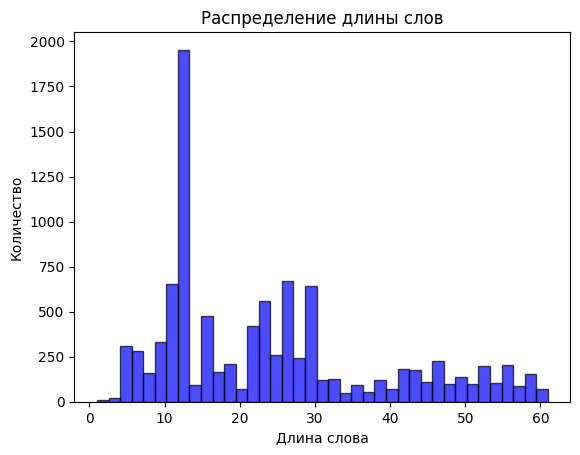

In [37]:
expr_lengths = df['Math expression'].apply(len)

plt.hist(expr_lengths, bins='auto', alpha=0.7, color='blue', edgecolor='black')
plt.title('Распределение длин выражений')
plt.xlabel('Длина слова')
plt.ylabel('Количество')
plt.show()

In [47]:
df['Result'] = pd.to_numeric(df['Result'], errors='coerce')

In [65]:
print(f'Минимальное значение выражения: {df['Result'].min()}')
print(f'Максимальное значение выражения: {df['Result'].max()}')
print(f'Величина 0.95 квантиля: {df['Result'].quantile(0.95)}')

Минимальное значение выражения: -1666971
Максимальное значение выражения: 118422
Величина 0.95 квантиля: 170.0


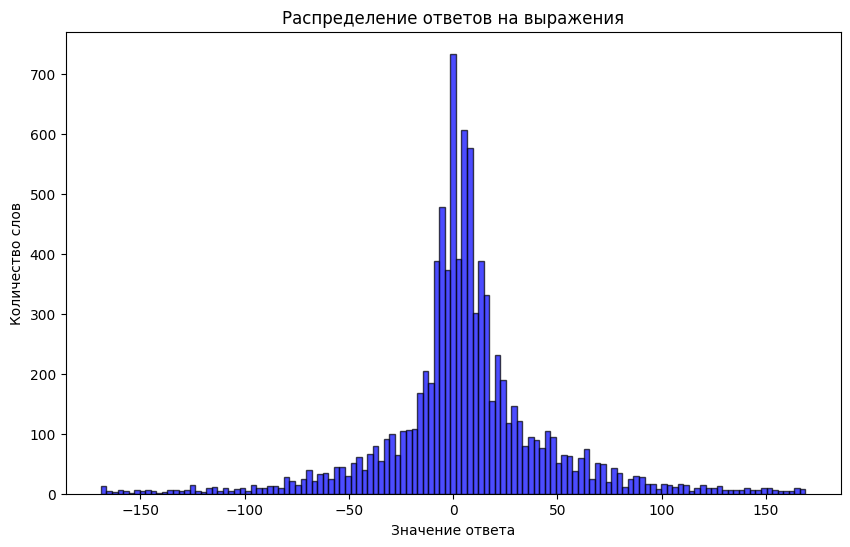

In [67]:
plt.figure(figsize=(10, 6))
plt.hist(df['Result'][(df['Result'] > -170) & (df['Result'] < 170)], bins='auto', alpha=0.7, color='blue', edgecolor='black')
plt.title('Распределение ответов на выражения')
plt.xlabel('Значение ответа')
plt.ylabel('Количество слов')

plt.show()

In [68]:
simple_mat_data = df.drop(df[(df['Result'] > 170) | (df['Result'] < -170)].index)

In [72]:
#simple_mat_data.to_csv('simple_mat_expr.csv', sep = '\t', index = False)

## Вычисление производных с помощью sympy

In [6]:
x = sympy.symbols('x')
expression = x**2 + 3*x + 2
derivative = sympy.diff(expression, x)
derivative_str = str(derivative)

print("Исходное выражение:", expression)
print("Производная:", derivative_str)

Исходное выражение: x**2 + 3*x + 2
Производная: 2*x + 3


In [7]:
expression = sympy.sqrt(sympy.cos(sympy.cos(x**2)))
derivative = sympy.diff(expression, x)
point = 2
derivative_at_point = derivative.subs(x, point)

print(f"Исходное выражение: {expression}")
print(f"Производная: {derivative}")
print(f"Значение производной в точке {point}: {derivative_at_point}")

Исходное выражение: sqrt(cos(cos(x**2)))
Производная: x*sin(x**2)*sin(cos(x**2))/sqrt(cos(cos(x**2)))
Значение производной в точке 2: 2*sin(4)*sin(cos(4))/sqrt(cos(cos(4)))


## Генерация датасета производных

In [114]:
class Node:
    def __init__(self, node_type, value=None, operator=None):
        self.node_type = node_type
        self.value = value
        self.operator = operator
        self.children = []

def generate_literal():

    rand_num = np.random.rand()
    if (rand_num < 0.2):
        return Node('literal', value=np.random.randint(0, 10))
    else:
        return Node('literal', value='x')

def generate_grouping(depth):
    node = Node('grouping')
    node.children.append(generate_expression(depth - 1))
    return node

def generate_function(depth):
    node = Node('func', operator=np.random.choice(['sin', 'cos','ln','exp','sqrt']))
    node.children.append(generate_expression(depth - 1))
    return node
    
def generate_unary(depth):
    node = Node('unary', operator=np.random.choice(['-']))
    node.children.append(generate_expression(depth - 1))
    return node

def generate_binary(depth):
    node = Node('binary', operator=np.random.choice(['+', '-', '*', '/']))
    node.children.append(generate_expression(depth - 1))
    node.children.append(generate_expression(depth - 1))
    return node

def generate_expression(depth):
    numbers = [1, 2, 3, 4, 5]
    
    probabilities = np.array([0.01, 0.5, 0.8, 0.6, 0.1], dtype=float)
    probabilities /= probabilities.sum()
    rand_num = np.random.choice(numbers, p=probabilities)
    
    if depth == 0 or rand_num == 1:
        return generate_literal()
    elif rand_num == 2:
        return generate_unary(depth)
    elif rand_num == 3:
        return generate_binary(depth)
    elif rand_num == 4:
        return generate_function(depth)
    else:
        return generate_grouping(depth)

def tree_to_string(node):

    if node.node_type == 'literal':
        return str(node.value)
    elif node.node_type == 'grouping':
        return f"({tree_to_string(node.children[0])})"
    elif node.node_type == 'unary':
        return f"{node.operator}{tree_to_string(node.children[0])}"
    elif node.node_type == 'func':
        return f"{node.operator}({tree_to_string(node.children[0])})"
    elif node.node_type == 'binary':
        return f"{tree_to_string(node.children[0])} {node.operator} {tree_to_string(node.children[1])}"


def generate_and_differentiate(min_depth = 1, max_depth = 5):
    math_tree = generate_expression(depth=np.random.randint(min_depth, max_depth))
    math_string = tree_to_string(math_tree)

    derivative = sympy.diff(math_string, x)
    if 'zoo' not in str(derivative):
        return {'Math expression': math_string, 'Derivative': str(derivative)}
    else:
        return {'Math expression': math_string, 'Derivative': 'ZeroDivision'}


In [115]:
# Пример выражения
math_tree = generate_expression(depth=np.random.randint(1, 4))
math_string = tree_to_string(math_tree)
derivative = sympy.diff(math_string, x)
derivative_str = str(derivative)

print("Исходное выражение:", math_string)
print("Производная:", derivative_str)

Исходное выражение: cos(-exp(7))
Производная: 0


In [116]:
x = symbols('x')

data_set = set()
data = []
num_of_expr = 15000

In [126]:
def create_diff_dataset(min_depth = 1, max_depth = 5, num_of_expr = 100, data = None):
    
    if (not data):
        data = []
        
    data_set = set(data)
    
    while len(data) < num_of_expr:
        result = generate_and_differentiate(min_depth, max_depth)
        math_tree_string = result['Math expression']
    
        if math_tree_string not in data_set:
            data_set.add(math_tree_string)
            data.append(result)
            
            if len(data)%1000 == 0:
                print(len(data))
    return data


In [120]:
data_diff = create_diff_dataset(min_depth = 1, max_depth = 10, num_of_expr = 15000, data = None)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000


""


In [122]:
diff_df = pd.DataFrame(data_diff)
diff_df.head()

,Math expression,Derivative
0,-ln(x) + exp(x),exp(x) - 1/x
1,cos(sqrt(--cos(x) + (sqrt(x)) + --(-6)) * sqrt...,-((-sin(x)/2 + 1/(4*sqrt(x)))*sqrt(exp(x**2 + ...
2,-(-1),0
3,-sqrt(-sqrt(cos(-(-x / -x)))),0
4,x / x,0


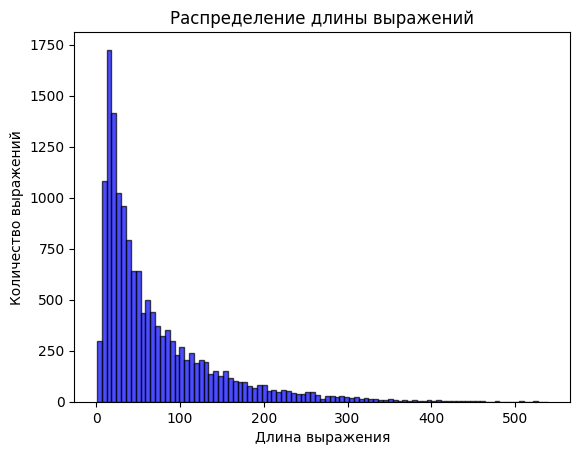

In [123]:
expr_lengths = diff_df['Math expression'].apply(len)

plt.hist(expr_lengths, bins='auto', alpha=0.7, color='blue', edgecolor='black')
plt.title('Распределение длины выражений')
plt.xlabel('Длина выражения')
plt.ylabel('Количество выражений')
plt.show()

Распределение похоже на экспоненциальное, но длины выражений в основном слишком велики, сгенерируем новый набор данных с меньшей глубиной деревьев

In [183]:
data_diff = create_diff_dataset(min_depth = 1, max_depth = 5, num_of_expr = 15000, data = None)
diff_df = pd.DataFrame(data_diff)
diff_df.head()

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000


,Math expression,Derivative
0,sin(x + x),2*cos(2*x)
1,(x),1
2,sin(exp((sqrt(x)))),exp(sqrt(x))*cos(exp(sqrt(x)))/(2*sqrt(x))
3,exp(x) + sin(x),exp(x) + cos(x)
4,ln(sqrt(x / x)),0


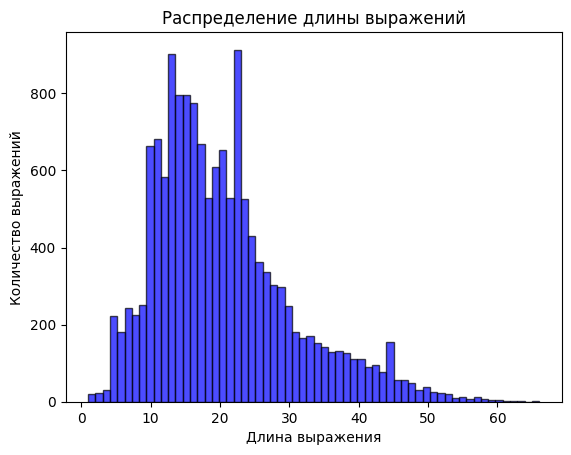

In [184]:
expr_lengths = diff_df['Math expression'].apply(len)

plt.hist(expr_lengths, bins='auto', alpha=0.7, color='blue', edgecolor='black')
plt.title('Распределение длины выражений')
plt.xlabel('Длина выражения')
plt.ylabel('Количество выражений')
plt.show()

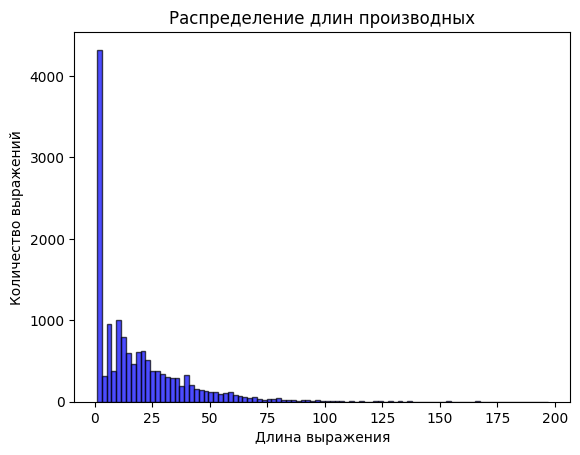

In [185]:
expr_lengths = diff_df['Derivative'].apply(len)

plt.hist(expr_lengths, bins='auto', alpha=0.7, color='blue', edgecolor='black')
plt.title('Распределение длин производных')
plt.xlabel('Длина выражения')
plt.ylabel('Количество выражений')
plt.show()

In [186]:
print(f'Количество выражений с производной 0: {diff_df['Derivative'][diff_df['Derivative'] == '0'].size}')
print(f'Количество выражений с производной 1: {diff_df['Derivative'][diff_df['Derivative'] == '1'].size}')
print(f'Количество выражений с производной 2: {diff_df['Derivative'][diff_df['Derivative'] == '2'].size}')
print(f'Количество выражений с производной 3: {diff_df['Derivative'][diff_df['Derivative'] == '3'].size}')
print(f'Количество выражений с производной 4: {diff_df['Derivative'][diff_df['Derivative'] == '4'].size}')
print(f'Количество выражений с производной 5: {diff_df['Derivative'][diff_df['Derivative'] == '5'].size}')
print(f'Количество выражений с производной 6: {diff_df['Derivative'][diff_df['Derivative'] == '6'].size}')
print(f'Количество выражений с производной 7: {diff_df['Derivative'][diff_df['Derivative'] == '7'].size}')
print(f'Количество выражений с производной 8: {diff_df['Derivative'][diff_df['Derivative'] == '8'].size}')
print(f'Количество выражений с производной 9: {diff_df['Derivative'][diff_df['Derivative'] == '9'].size}')

Количество выражений с нулевой производной: 2415
Количество выражений с единичной производной: 475
Количество выражений с производной 2: 151
Количество выражений с производной 3: 38
Количество выражений с производной 4: 22
Количество выражений с производной 5: 19


In [187]:
zeros_df = diff_df[diff_df['Derivative'] == '0']
indices_to_remove_zeros = zeros_df.sample(n=2000, random_state=42).index

ones_df = diff_df[diff_df['Derivative'] == '1']
indices_to_remove_ones = ones_df.sample(n=200, random_state=42).index
combined_indices = pd.Index(list(indices_to_remove_zeros) + list(indices_to_remove_ones))

diff_df = diff_df.drop(combined_indices)

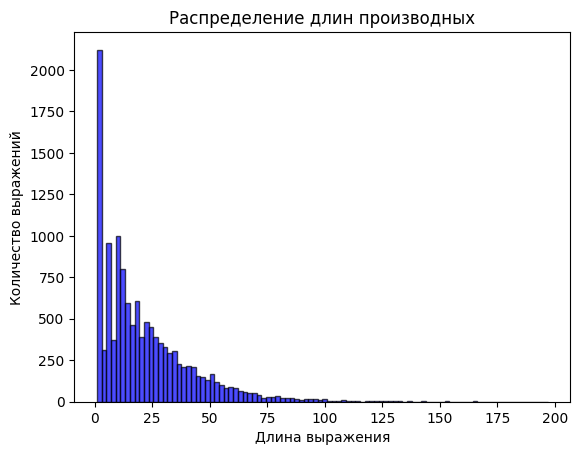

In [188]:
expr_lengths = diff_df['Derivative'].apply(len)

plt.hist(expr_lengths, bins='auto', alpha=0.7, color='blue', edgecolor='black')
plt.title('Распределение длин производных')
plt.xlabel('Длина выражения')
plt.ylabel('Количество выражений')
plt.show()

In [190]:
print(f'Количество выражений с производной 0: {diff_df['Derivative'][diff_df['Derivative'] == '0'].size}')
print(f'Количество выражений с производной 1: {diff_df['Derivative'][diff_df['Derivative'] == '1'].size}')
print(f'Количество выражений с производной 2: {diff_df['Derivative'][diff_df['Derivative'] == '2'].size}')
print(f'Количество выражений с производной 3: {diff_df['Derivative'][diff_df['Derivative'] == '3'].size}')
print(f'Количество выражений с производной 4: {diff_df['Derivative'][diff_df['Derivative'] == '4'].size}')
print(f'Количество выражений с производной 5: {diff_df['Derivative'][diff_df['Derivative'] == '5'].size}')
print(f'Количество выражений с производной 6: {diff_df['Derivative'][diff_df['Derivative'] == '6'].size}')
print(f'Количество выражений с производной 7: {diff_df['Derivative'][diff_df['Derivative'] == '7'].size}')
print(f'Количество выражений с производной 8: {diff_df['Derivative'][diff_df['Derivative'] == '8'].size}')
print(f'Количество выражений с производной 9: {diff_df['Derivative'][diff_df['Derivative'] == '9'].size}')

Количество выражений с производной 0: 415
Количество выражений с производной 1: 275
Количество выражений с производной 2: 151
Количество выражений с производной 3: 38
Количество выражений с производной 4: 22
Количество выражений с производной 5: 19
Количество выражений с производной 6: 15
Количество выражений с производной 7: 17
Количество выражений с производной 8: 20
Количество выражений с производной 9: 17


In [195]:
print(f'Величина 0.95 квантиля: {expr_lengths.quantile(0.95)}')

Величина 0.95 квантиля: 62.0


In [196]:
expr_lengths.size

12800

In [199]:
diff_df_cut = diff_df[expr_lengths < 62]

In [205]:
diff_df_cut.shape

(12124, 2)

In [207]:
#diff_df_cut.to_csv('diff_data.csv', sep = '\t', index = False)